# Example: Implementing a pairing-based signature scheme

Cryptimeleon Math is a library supplying the mathematical basics for cryptography.

In this notebook, we'll take a look at how to implement a pairing-based scheme.

The (multi-message) [Pointcheval-Sanders signature scheme](https://eprint.iacr.org/2015/525) is a very useful digital signature scheme for advanced cryptographic constructions because of its elegant and simple algebraic structure. We'll use it as an example for implementing a cryptographic scheme.

We'll work alongside the scheme's definition in the paper:
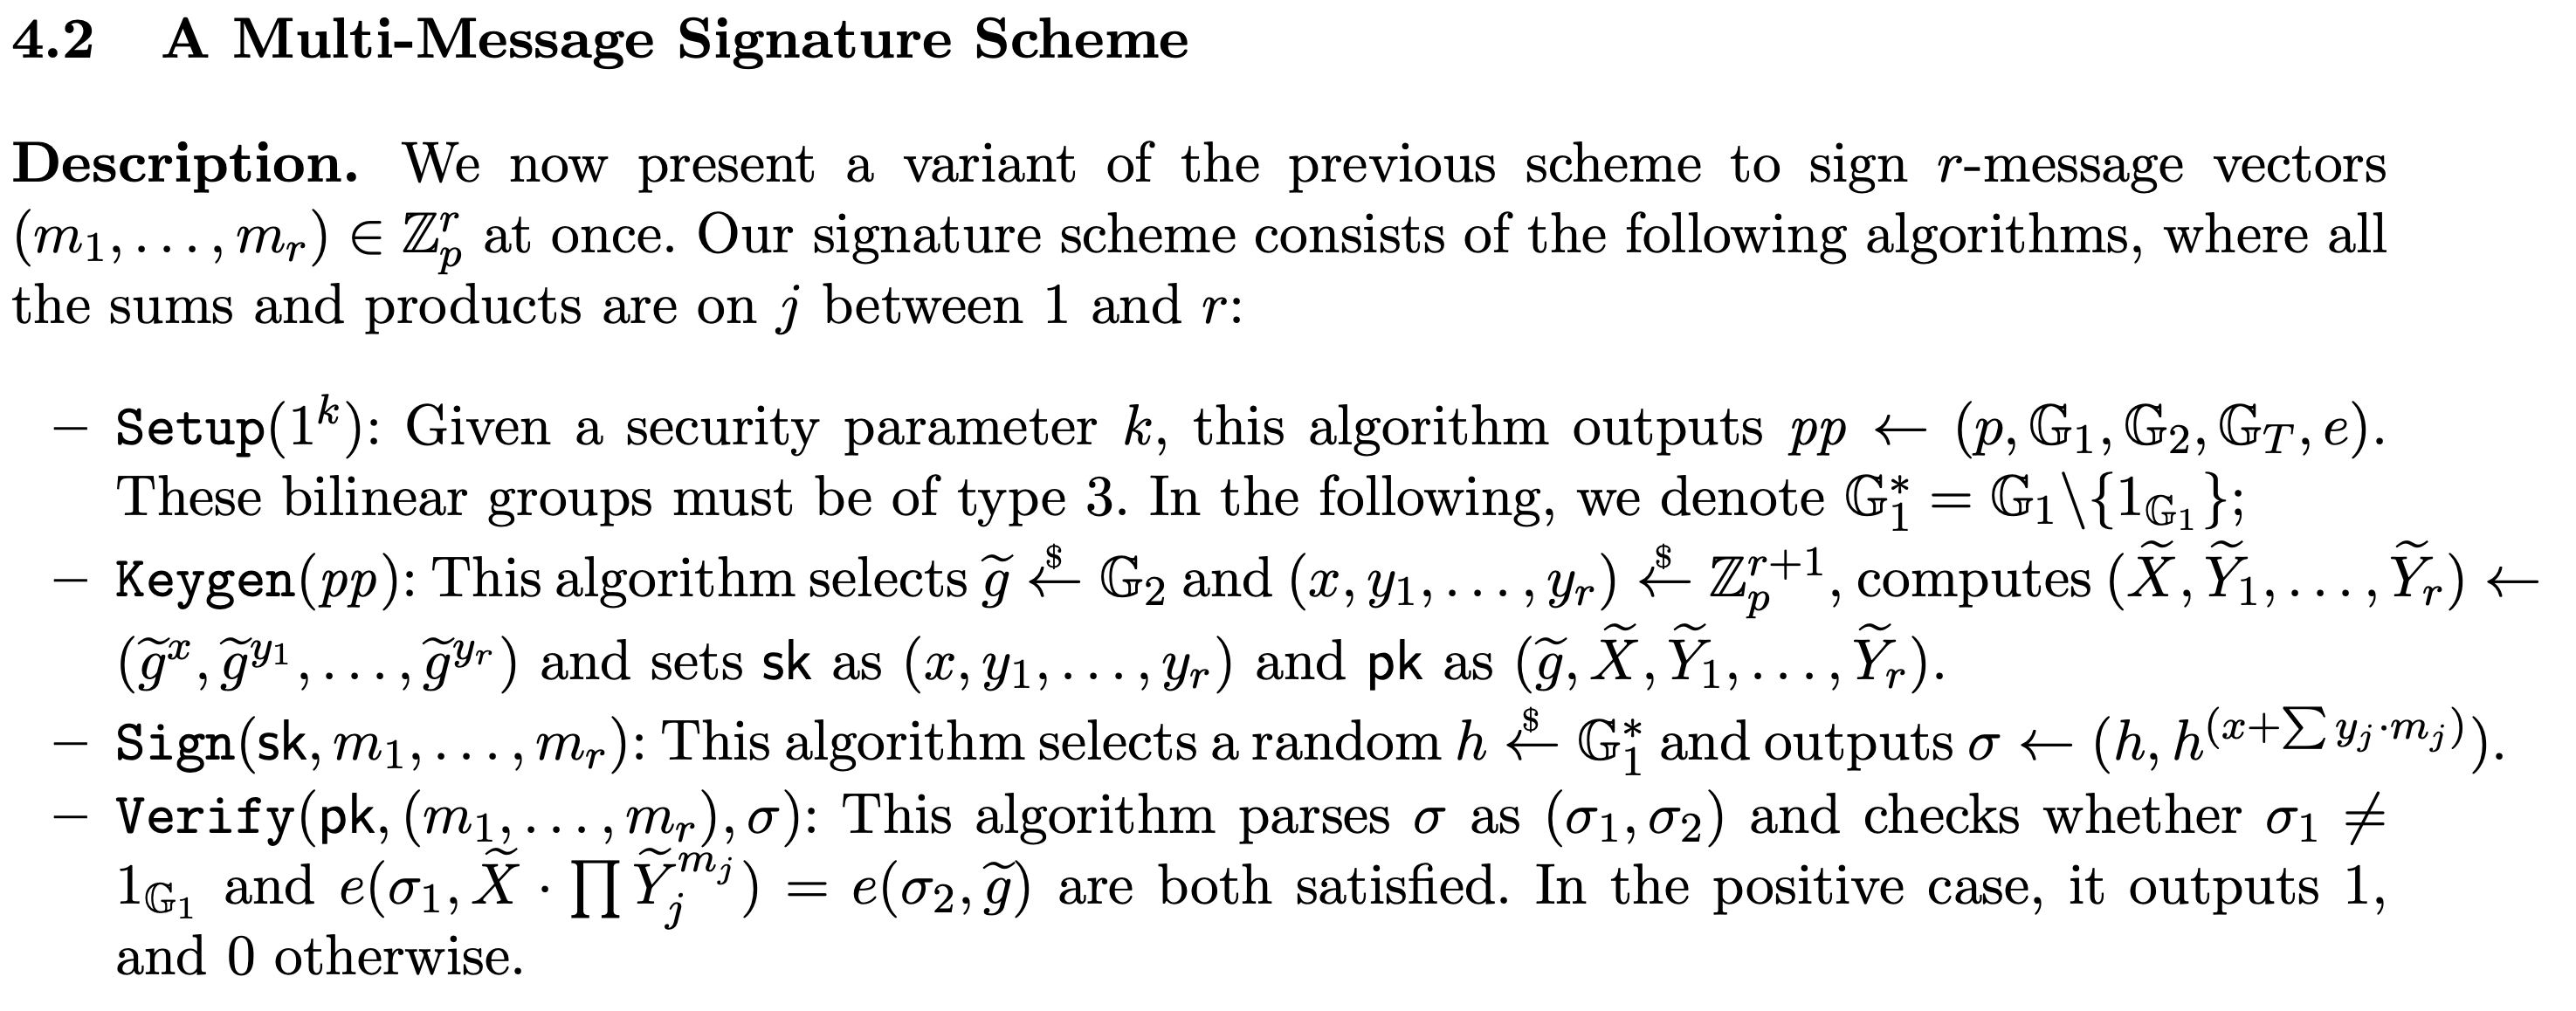

... and show how to implement it. 

<hr>

## Setting up the bilinear group

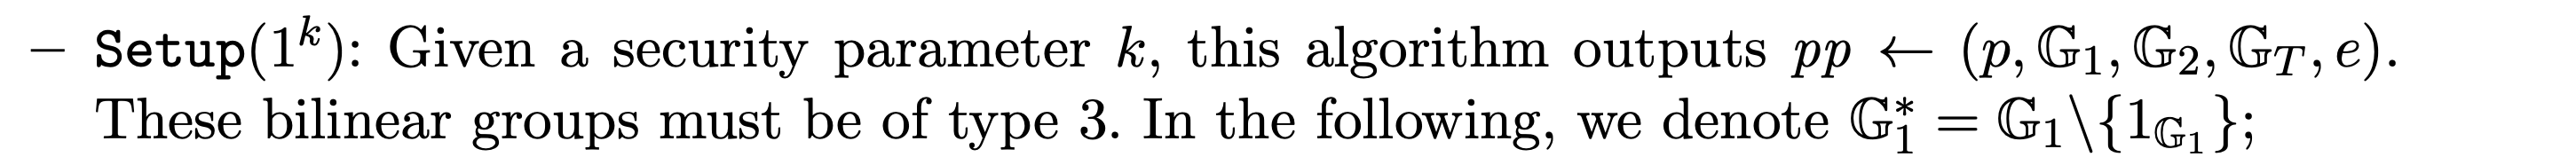
First, we need to set up the bilinear group setting required for the scheme. We need to know the type of pairing and the desired security parameter. In this case we want a type 3 pairing and 100 bit security.

In [ ]:
%maven org.cryptimeleon:math:1.0.0

In [ ]:
import org.cryptimeleon.math.structures.groups.elliptic.*;
import org.cryptimeleon.math.structures.groups.elliptic.type3.bn.BarretoNaehrigBilinearGroup;
import org.cryptimeleon.math.structures.groups.*;
import org.cryptimeleon.math.structures.groups.mappings.*;
import org.cryptimeleon.math.structures.rings.zn.*;

// Choose number of messages r
var r = 3;

// BN pairing is type 3 and we specify a 100 bit security parameter
BilinearGroup bilinearGroup = new BarretoNaehrigBilinearGroup(100);

// Let's collect the values for our pp
Group groupG1 = bilinearGroup.getG1();
Group groupG2 = bilinearGroup.getG2();
Group groupGT = bilinearGroup.getGT();
BilinearMap e = bilinearGroup.getBilinearMap();
BigInteger p = groupG1.size();
Zn zp = bilinearGroup.getZn();
System.out.println("Generated bilinear group of order " + p);

## Generating a key pair

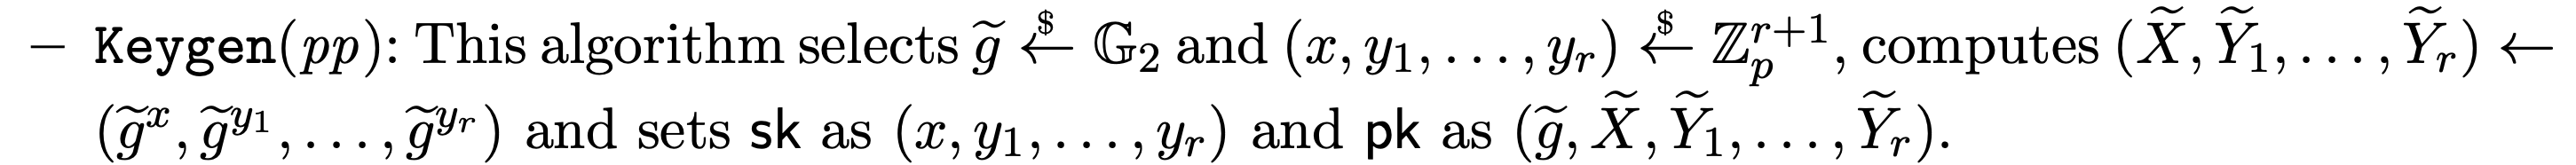

For a key pair, we need to generate random exponents $x$ and $y_i$ as the secret key. Because it's a group of order $p$, we interpret the exponents as elements of $\mathbb{Z}_p$. 

In [ ]:
// Generate secret key

var x = zp.getUniformlyRandomElement();
var y = zp.getUniformlyRandomElements(r); //computes a vector of r random numbers y_0, ..., y_(r-1)

System.out.println("x = " + x);
System.out.println("y = " + y);

Then we can compute the corresponding public key easily and run precomputation on it to speed up later verifications:

In [ ]:
// Generate public key

var tildeg = groupG2.getUniformlyRandomElement();
var tildeX = tildeg.pow(x).precomputePow(); // this computes X = tildeg^x as above and runs precomputations to speed up later pow() calls on tildeX
var tildeY = tildeg.pow(y).precomputePow(); // because y is a vector, this yields a vector of values tildeg.pow(y_0), tildeg.pow(y_1), ...

In [ ]:
System.out.println("tildeg = " + tildeg);
System.out.println("tildeX = " + tildeX);
System.out.println("tildeY = " + tildeY);




## Computing a signature

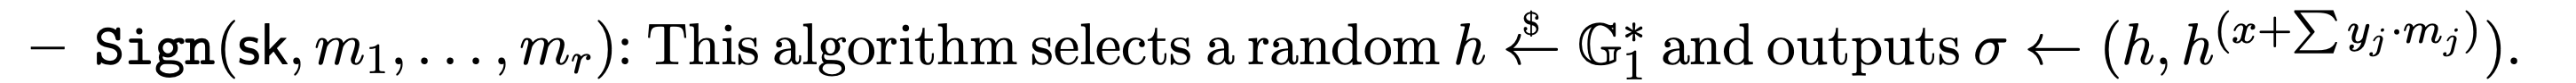

Computing a signature works as you'd expect now with what we've already seen. Messages for Pointcheval-Sanders lie in $\mathbb{Z}_p$, but we can use a hash function $\mathcal{H}:\{0,1\}\rightarrow \mathbb{Z}_p$ to sign arbitrary strings.

In [ ]:
import org.cryptimeleon.math.structures.rings.cartesian.RingElementVector;

// Preparing messages ("Hello PS sigs", 42, 0, 0, ...)
var m = new RingElementVector(
    bilinearGroup.getHashIntoZGroupExponent().hash("Hello PS sigs"), 
    zp.valueOf(42)).pad(zp.getZeroElement(), r
);

// Computing signature
var sigma1 = groupG1.getUniformlyRandomNonNeutral().compute(); // h
var sigma2 = sigma1.pow(x.add(y.innerProduct(m))).compute(); // h^{x + sum(y_i*m_i)}
// The compute() call is optional but will cause sigma1 and sigma2 to be computed concurrently in the background.

In [ ]:
System.out.println("sigma1 = " + sigma1);
System.out.println("sigma2 = " + sigma2);

## Verifying a signature

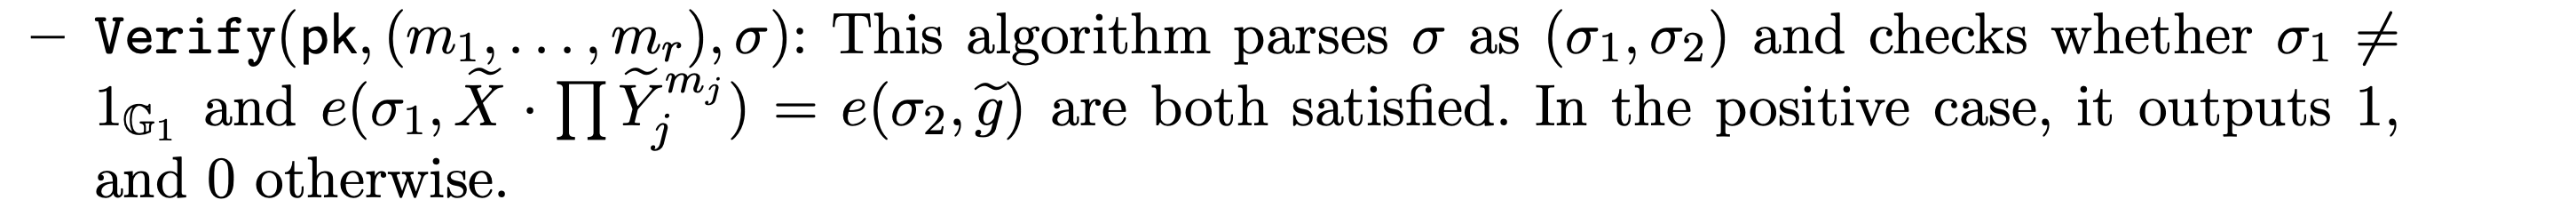

For this verification, we need to emply the pairing `e`.

In [ ]:
!sigma1.isNeutralElement() 
    && e.apply(sigma1, tildeX.op(tildeY.innerProduct(m))).equals(e.apply(sigma2, tildeg))

If this pairing computation seems slow, check out the [mclwrap](https://github.com/cryptimeleon/mclwrap) addon for a faster bilinear group.